# **Homework #3_P1**

## **Problem 1: VAE (30%)** 
### **Task Definition**
A variational autoencoder (VAE) is a type of neural network that learns to reproduce its input, and also map data to latent space. it is worth noting that a VAE model can generate samples by sampling from the latent space.
In this problem, you will implement a VAE model and train it on a face dataset. Also, you will conduct some experiments to analyze your VAE model. Please follow problems below:

In [ ]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
path = 'drive/My Drive/senior_1/DLCV/HW/hw3'

Mounted at /content/drive


In [ ]:
!gdown --id '1Cz5eLSP7QRMkO0PqxZLldJ36nK6EWHR8' --output hw3_data.zip # 下載資料集
!unzip hw3_data.zip # 解壓縮
# hw3_data/face/rain/images.png
# hw3_data/face/train.csv
# hw3_data/face/test/images.png
# hw3_data/face/test.csv

In [ ]:
# set packages
!pip3 install certifi==2020.6.20
!pip3 install cycler==0.10.0
!pip3 install joblib==0.17.0
!pip3 install kiwisolver==1.2.0
!pip3 install matplotlib==3.3.2
!pip3 install numpy==1.18.1
!pip3 install pandas==1.1.3
!pip3 install Pillow==8.0.0
!pip3 install pyparsing==2.4.7
!pip3 install python-dateutil==2.8.1
!pip3 install pytz==2020.1
!pip3 install scikit-learn==0.21.3
!pip3 install scipy==1.2.1
!pip3 install six==1.15.0
!pip3 install torch==1.4.0
!pip3 install torchvision==0.5.0

In [ ]:
# Import 需要的套件
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import time
import pandas as pd
import random
import scipy.misc
import argparse
import imageio
from torch.autograd import Variable
from torch.optim import Adam, AdamW
import csv
from sklearn.manifold import TSNE

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("torchvision.__version__ =", torchvision.__version__)
    print("torch.cuda.is_available() =", torch.cuda.is_available())

same_seeds(0)

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


#Read image

In [ ]:
def sortfile(path):
    index = []
    image_dir = sorted(os.listdir(path)) # 把圖檔按照編號排列
    for i, file in enumerate(image_dir):
        index.append([file, int(file.replace('.png', ''))])

    index = sorted(index, key = lambda s: s[1])

    return index

def readfile(path, index, mode):
    x = np.zeros((len(index), 64, 64, 3), dtype=np.uint8)
    for i, file in enumerate(index):
        img = imageio.imread(os.path.join(os.path.join(path, mode), file[0]))
        x[i, :, :] = img
    y = pd.read_csv(os.path.join(path, mode + ".csv"))       

    return x, y

In [ ]:
# 分別將 training set、testing set 用 sortfile, readfile 函式讀進來
workspace_dir = './hw3_data'
print("Reading data")

train_index = sortfile(os.path.join(workspace_dir, "face/train"))
train_x, train_y = readfile(os.path.join(workspace_dir, "face"), train_index, "train")
print("finish training_data")

test_index = sortfile(os.path.join(workspace_dir, "face/test"))
test_x, test_y = readfile(os.path.join(workspace_dir, "face"), test_index, "test")
print("finish testing_data")

Reading data
finish training_data
finish testing_data


# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。


In [ ]:
class ImgDataset(Dataset):
    def __init__(self, x, transform=None):
        self.x = torch.FloatTensor(x)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        X = (self.x[index]/255)*2-1 # norm to [-1, 1]
        X = X.permute(2, 1, 0)

        return X

# Model

## Linear

In [ ]:
# linear deep
class VAE_Linear(nn.Module):
    def __init__(self):
        super(VAE_Linear, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(64*64*3, 1024),
            nn.LeakyReLU(0.2),
        )
        self.mean = nn.Sequential(
            nn.Linear(1024, 512),
        )
        self.var = nn.Sequential(
            nn.Linear(1024, 512),
        )
        self.decoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*64*3),
            nn.Tanh()
        )

    def reparametrize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        hidden_1 = self.encoder(x) # hidden_1
        hidden_2_mu = self.mean(hidden_1) # hidden_2 (mean)
        hidden_2_logvar = self.var(hidden_1) # hidden_2 (var)
        z = self.reparametrize(hidden_2_mu, hidden_2_logvar) # 重新參數化成正態分布
        reconstruct = self.decoder(z)
        return reconstruct, hidden_2_mu, hidden_2_logvar # 解碼，同時輸出均值方差

def loss_vae(recon_x, x, mu, logvar, criterion, weighted):
    # recon_data = (((recon_x+1)/2*255)).cuda().round()
    # data = ((x+1)/2*255).cuda().round()
    MSE_back = criterion(recon_x, x) # MSE
    # MSE_data = criterion(recon_data, data) # pixel-wise avg MSE
    KLD_back = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL divergence

    return MSE_back+weighted*KLD_back, MSE_back, KLD_back

## CNN

In [ ]:
# deep conv
class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()
        self.latent_dim = 1024

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),         # [batch_size, 64, 32, 32]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),       # [batch_size, 128, 16, 16]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),      # [batch_size, 256, 8, 8]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),      # [batch_size, 512, 4, 4]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),     # [batch_size, 1024, 2, 2]
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.01, inplace=True),
        )
        

        self.mean = nn.Sequential(
            nn.Linear(1024*2*2, self.latent_dim),                         # [batch_size, self.latent_dim]
        )
        self.var = nn.Sequential(
            nn.Linear(1024*2*2, self.latent_dim),                         # [batch_size, self.latent_dim]
        )
        self.decoder_input = nn.Sequential(                               # [batch_size, 1024*2*2]
            nn.Linear(self.latent_dim, 1024*2*2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),  # [batch_size, 512, 4, 4]
            nn.BatchNorm2d(512),  
            nn.LeakyReLU(0.01, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),   # [batch_size, 256, 8, 8]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),   # [batch_size, 128, 16, 16]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),    # [batch_size, 64, 32, 32]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),      # [batch_size, 3, 64, 64]
            nn.Tanh()
        )

    def reparametrize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        hidden_1 = self.encoder(x) # hidden_1
        hidden_1 = hidden_1.view(hidden_1.size()[0], -1) # hidden_1 flatten

        hidden_2_mu = self.mean(hidden_1) # hidden_2 (mean)
        hidden_2_logvar = self.var(hidden_1) # hidden_2 (var)
        z = self.reparametrize(hidden_2_mu, hidden_2_logvar) # get latent

        decoder_input = self.decoder_input(z) # get decoder_input
        decoder_input = decoder_input.view(decoder_input.size()[0], self.latent_dim, 2, 2) # transpose to 2d
        reconstruct = self.decoder(decoder_input)
        return reconstruct, hidden_2_mu, hidden_2_logvar # 解碼，同時輸出均值方差

def loss_vae(recon_x, x, mu, logvar, criterion, weighted):
    # recon_data = (((recon_x+1)/2*255)).cuda().round()
    # data = ((x+1)/2*255).cuda().round()
    MSE_back = criterion(recon_x, x) # MSE
    # MSE_data = criterion(recon_data, data) # pixel-wise avg MSE
    KLD_back = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL divergence

    return MSE_back+weighted*KLD_back, MSE_back, KLD_back

In [ ]:
from torchsummary import summary

model = VAE_CNN().cuda()
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13           [-1, 1024, 2, 2]       4,719,616
      BatchNorm2d-14           [-1, 102

# Training

使用 training set 訓練

In [ ]:
# data_set
batch_size = 64
# train_x = train_x.reshape(len(train_x), -1) # for LinearVAE
train_set = ImgDataset(train_x)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# training
num_epochs = 50
criterion = nn.MSELoss()
best_loss = np.inf
best_MSE = np.inf
MSE_data = []
KLD_data = []

model = VAE_CNN().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

for epoch in range(num_epochs):
    model.train()
    training_start_time = time.time()
    MSE = 0
    KLD = 0
    index = 0
    weighted = 0.00001
    # if epoch < 200:
    #     weighted = 0.00001
    # elif epoch >= 200 and epoch < 1000:
    #     weighted = 0.0001
    # else:
    #     weighted = 0.001
    for data in train_dataloader:
        print('batch', index)
        # ===================forward=====================
        output = model(data.cuda())
        loss, mse, kld = loss_vae(output[0], data.cuda(), output[1], output[2], criterion, weighted)
        MSE += mse.item()
        KLD += kld.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        index += 1
        # ===================save====================
    MSE_data.append(MSE/(40000/batch_size)) # avg MSE
    KLD_data.append(KLD/(40000/batch_size)) # avg KLD
    total_batch_loss = MSE/(40000/batch_size) + weighted*KLD/(40000/batch_size)

    # if  MSE_data[epoch] < best_MSE:
    #     torch.save(model.state_dict(), os.path.join(path, 'G_p1_model_LinearVAE.pkl'))
    #     print('save model')

    if  total_batch_loss < best_loss:
        best_loss = total_batch_loss
        torch.save(model.state_dict(), os.path.join(path, 'p1_model_CNNVAE.pkl'))
        print('save model')
        # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}, training cost time:{:.4f} (sec), MSE:{:.4f}, KLD:{:.4f}, best loss:{:.4f}'
              .format(epoch + 1, num_epochs, total_batch_loss, time.time() - training_start_time, MSE_data[epoch], KLD_data[epoch], best_loss))

#Report (30%)

1. Build your VAE encoder and decoder model and print the architecture [fig1_1.png] (Please use “print(model)” in PyTorch directly). Then, train your model on the face dataset and describe implementation details of your model. (Include but not limited to training epochs, learning rate schedule, data augmentation and optimizer) (5%)

In [ ]:
print(VAE_CNN())

VAE_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1

2. Please plot the learning curve (reconstruction loss and KL divergence) of your model. [fig1_2.png] (5%)

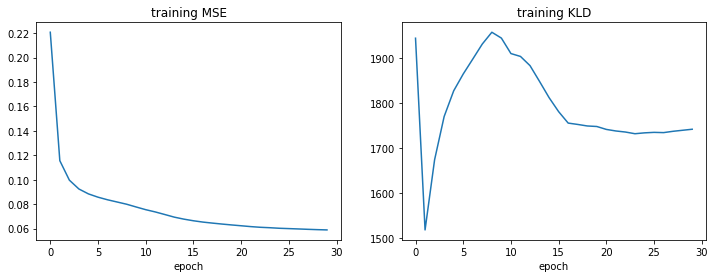

In [ ]:
import  matplotlib.pyplot as plt

# epoch = 30
# save
MSE_list = np.array(MSE_data)
np.save(os.path.join(path, 'p1_CNNVAE_MSE.npy'), MSE_list) 
KLD_list = np.array(KLD_data)
np.save(os.path.join(path, 'p1_CNNVAE_KLD.npy'), KLD_list) 

# load
MSE_list = np.load(os.path.join(path, 'p1_CNNVAE_MSE.npy'))
KLD_list = np.load(os.path.join(path, 'p1_CNNVAE_KLD.npy'))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("training MSE")
plt.xlabel("epoch")
plt.plot(MSE_list)

plt.subplot(1, 2, 2)
plt.title("training KLD")
plt.xlabel("epoch")
plt.plot(KLD_list)

plt.show()

3. Please random choose 10 testing images and get the reconstructed images from your VAE model. Plot 10 testing images and their reconstructed results
(reconstructed images and MSE) from your model. [Table 1_3] (5%)

In [ ]:
# data_set
batch_size = 1
# test_x = test_x.reshape(len(test_x), -1)
test_set = ImgDataset(test_x)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
# test_set = ImgDataset(train_x)
# test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
model = VAE_CNN().cuda()
model.load_state_dict(torch.load(os.path.join(path, 'p1_model_CNNVAE.pkl')))
model.eval()

criterion = nn.MSELoss()
MSE_data = []
KLD_data = []
test_input = []
test_output = []
index = 0

for data in test_dataloader:
    output = model(data.cuda())
    loss, mse, kld = loss_vae(output[0], data.cuda(), output[1], output[2], criterion, 0.001)
    if mse.item() < 0.06:
      test_input.append(np.around(((data[0]+1)/2*255).permute(2, 1, 0).data.cpu().numpy()).astype(int))
      test_output.append(np.around(((output[0][0]+1)/2*255).permute(2, 1, 0).data.cpu().numpy()).astype(int))
      MSE_data.append(mse.item())
      KLD_data.append(kld.item()) 
      index += 1
    if index == 10:
        break

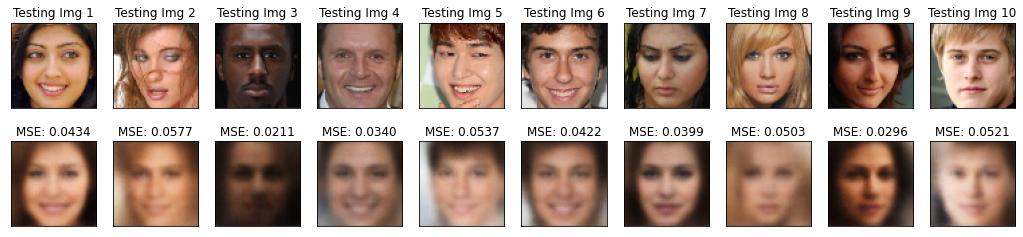

In [ ]:
import  matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))
for i in range(len(test_input)):
    plt.subplot(2, 10, i+1)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.title('Testing Img ' + str(i+1))
    plt.imshow(test_input[i])

    plt.subplot(2, 10, i+11)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.title('MSE: {:.4f}'.format(MSE_data[i]))
    plt.imshow(test_output[i])
plt.show()

4. Now, we utilize decoder in VAE model to randomly generate images by sampling latent vectors from an Normal distribution. Please Plot 32 random
generated images from your model. [fig1_4.jpg] (5%)    
    **You should fix the random seed in your program such that the [fig1_4.jpg] produced by your script is exactly the same as the one in your report.**

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


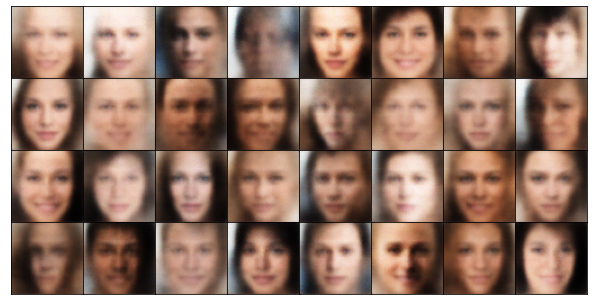

In [ ]:
# import  matplotlib.pyplot as plt
# model = VAE_CNN().cuda()
# model.load_state_dict(torch.load(os.path.join(path, 'p1_model_CNNVAE.pkl')))
# model.eval()
# sample_output = []
# same_seeds(0)

# for i in range(32):
#     # sample = model.reparametrize(torch.FloatTensor([0]*model.latent_dim).view(-1, model.latent_dim).cuda(), 
#     #                              torch.FloatTensor([0]*model.latent_dim).view(-1, model.latent_dim).cuda())
#     sample = model.reparametrize(torch.rand(1, model.latent_dim).cuda(), torch.rand(1, model.latent_dim).cuda())
#     decoder_input = model.decoder_input(sample) # get decoder_input
#     decoder_input = decoder_input.view(decoder_input.size()[0], model.latent_dim, 2, 2) # transpose to 2d
#     reconstruct = model.decoder(decoder_input)
#     sample_output.append(np.around(((reconstruct[0]+1)/2*255).permute(2, 1, 0).data.cpu().numpy()).astype(int))

#     plt.subplot(4, 8, i+1)
#     fig = plt.gcf()
#     fig.set_size_inches(8, 4) 
#     plt.gca().xaxis.set_major_locator(plt.NullLocator())
#     plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#     plt.margins(0,0)
#     plt.imshow(sample_output[i])

# plt.savefig(os.path.join(path, 'p1_sample.jpg'))
# plt.show()

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


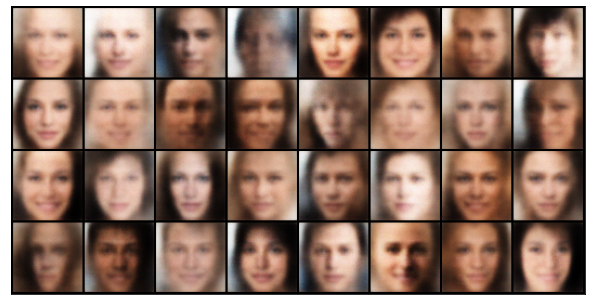

In [ ]:
# # use torch to save img
# import  matplotlib.pyplot as plt
# model = VAE_CNN().cuda()
# model.load_state_dict(torch.load(os.path.join(path, 'p1_model_CNNVAE.pkl')))
# model.eval()
# same_seeds(0)

# sample_output = np.zeros([32, 64, 64, 3])

# for i in range(32):
#     sample = model.reparametrize(torch.rand(1, model.latent_dim).cuda(), torch.rand(1, model.latent_dim).cuda())
#     decoder_input = model.decoder_input(sample) # get decoder_input
#     decoder_input = decoder_input.view(decoder_input.size()[0], model.latent_dim, 2, 2) # transpose to 2d
#     reconstruct = model.decoder(decoder_input)
#     sample_output[i] = np.around(((reconstruct[0]+1)/2*255).permute(2, 1, 0).data.cpu().numpy()).astype(int)

# torchvision.utils.save_image(torch.tensor(sample_output).permute(0, 3, 1, 2), os.path.join(path, 'p1_sample.jpg'), nrow=8, normalize=True)
# grid_img = torchvision.utils.make_grid(torch.tensor(sample_output).permute(0, 3, 1, 2), nrow=8, normalize=True)
# fig = plt.gcf()
# fig.set_size_inches(8, 4) 
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
# plt.margins(0,0)
# plt.imshow(grid_img.permute(1, 2, 0))
# plt.show()

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


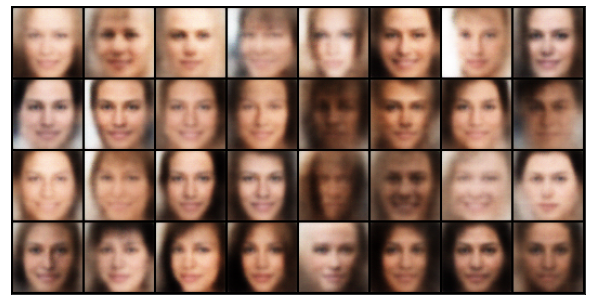

In [ ]:
# use torch to save img
import  matplotlib.pyplot as plt
model = VAE_CNN().cuda()
model.load_state_dict(torch.load(os.path.join(path, 'p1_model_CNNVAE.pkl')))
model.eval()
same_seeds(0)

sample_output = np.zeros([32, 64, 64, 3])
sample = model.reparametrize(torch.rand(32, model.latent_dim).cuda(), torch.rand(32, model.latent_dim).cuda())
decoder_input = model.decoder_input(sample) # get decoder_input
decoder_input = decoder_input.view(decoder_input.size()[0], model.latent_dim, 2, 2) # transpose to 2d
reconstruct = model.decoder(decoder_input)

for i in range(32):
    sample_output[i] = np.around(((reconstruct[i]+1)/2*255).permute(2, 1, 0).data.cpu().numpy()).astype(int)

torchvision.utils.save_image(torch.tensor(sample_output).permute(0, 3, 1, 2), os.path.join(path, 'p1_sample.jpg'), nrow=8, normalize=True)
grid_img = torchvision.utils.make_grid(torch.tensor(sample_output).permute(0, 3, 1, 2), nrow=8, normalize=True)
fig = plt.gcf()
fig.set_size_inches(8, 4) 
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

5. To analyze the latent space of your VAE model, please visualize the latent space by mapping the latent vectors of the test images to 2D space (by tSNE) and color them with respect to an attribute (e.g., gender and hair color) of your choice. (5%) (An example is shown below.)

In [ ]:
test_y

,image_name,Bangs,Big_Lips,Black_Hair,Blond_Hair,Brown_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Smiling,Straight_Hair,Wavy_Hair,Wearing_Lipstick
0,40000.png,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1,40001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,40002.png,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,40003.png,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,40004.png,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616,42616.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2617,42617.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2618,42618.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2619,42619.png,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [ ]:
# data_set
batch_size = len(test_x)
# test_x = test_x.reshape(len(test_x), -1)
test_set = ImgDataset(test_x)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
# visialize the latent space
model = VAE_CNN().cuda()
model.load_state_dict(torch.load(os.path.join(path, 'p1_model_CNNVAE.pkl')))
model.eval()
initial = True

for data in test_dataloader:
    hidden_1 = model.encoder(data.cuda())
    hidden_1 = hidden_1.view(hidden_1.size()[0], -1) # hidden_1 flatten
    hidden_2_mu = model.mean(hidden_1) # hidden_2 (mean)
    # hidden_2_logvar = model.var(hidden_1) # hidden_2 (var)

    if initial == True:
        latent_space = hidden_2_mu.data.cpu().numpy()
        initial = False
    else:
        latent_space = np.concatenate((latent_space, hidden_2_mu.data.cpu().numpy()), axis=0)

In [ ]:
latent_embedded = TSNE(n_components=2, perplexity=30.0, random_state=0).fit_transform(latent_space)

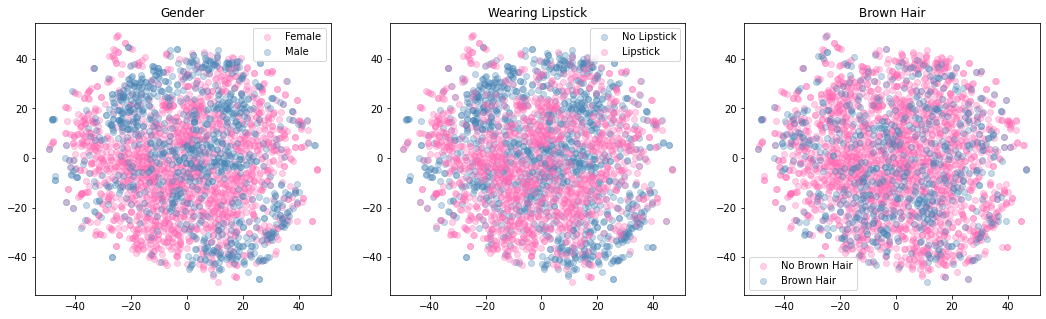

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

attr_arr = np.array(test_y["Male"])
for i in [0, 1]:
    if i == 1:
        color = "steelblue"
        mode = "Male"
    else:
        color = "hotpink"
        mode = "Female"
    xy = latent_embedded[attr_arr == i]
    label = attr_arr[attr_arr == i]
    ax1.scatter(xy[:, 0], xy[:, 1], c=color, label=mode, alpha=0.3)
ax1.legend()
ax1.set_title("Gender")

attr_arr = np.array(test_y["Wearing_Lipstick"])
for i in [0,1]:
    if i == 1:
        color = "hotpink"
        mode = "Lipstick"
    else:
        color = "steelblue"
        mode = "No Lipstick"
    xy = latent_embedded[attr_arr==i]
    label = attr_arr[attr_arr==i]
    ax2.scatter(xy[:, 0], xy[:, 1], c=color, label=mode, alpha=0.3)
ax2.legend()
ax2.set_title("Wearing Lipstick")

attr_arr = np.array(test_y["Brown_Hair"])
for i in [0,1]:
    if i == 1:
        color = "steelblue"
        mode = "Brown Hair"
    else:
        color = "hotpink"
        mode = "No Brown Hair"
    xy = latent_embedded[attr_arr==i]
    label = attr_arr[attr_arr==i]
    ax3.scatter(xy[:, 0], xy[:, 1], c=color, label=mode, alpha=0.3)
ax3.legend()
ax3.set_title("Brown Hair")

plt.savefig(os.path.join(path, 'p1_TSNE.jpg'))
plt.show()

6. Discuss what you’ve observed and learned from implementing VAE. (5%)